In [62]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [55]:
def id2name(team_id, team_df):
    name = team_df.loc[team_df['TEAM_ID']==team_id, 'NICKNAME'].values[0]
    return name


In [61]:
# Load the games data
NBA_games = pd.read_csv('games.csv', delimiter=',')
NBA_games = NBA_games[NBA_games['SEASON'] == 2022]
NBA_games = NBA_games[['SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']]
NBA_games.head()

,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS
0,2022,1610612740,1610612759,1
1,2022,1610612762,1610612764,1
2,2022,1610612739,1610612749,1
3,2022,1610612755,1610612765,1
4,2022,1610612737,1610612741,0


In [60]:
# Load team names
teams = pd.read_csv('teams.csv', delimiter=',')
teams = teams[['TEAM_ID', 'NICKNAME']]
teams.head()

,TEAM_ID,NICKNAME
0,1610612737,Hawks
1,1610612738,Celtics
2,1610612740,Pelicans
3,1610612741,Bulls
4,1610612742,Mavericks


In [59]:
# NBA_games['VISITOR_TEAM_ID']=NBA_games['VISITOR_TEAM_ID'].map(lambda x: id2name(x, teams))
# NBA_games.head()

In [63]:
def get_posterior(initial_point, num_samples, y, beta_inv, m_s, sigma_s):
    # Produce a posteroir from Gibbs sampling

    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2]) 
    samples[0] = point
    A = np.array([[1, -1]])
    
    for i in range(num_samples):
        s1_sample, s2_sample = samples[i]
        if y==1:
            t = stats.truncnorm.rvs(a=0, b=np.inf, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
        elif y==-1:
            t = stats.truncnorm.rvs(a=-np.inf, b=0, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))
            
        S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
        m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

        point = np.random.multivariate_normal(m.ravel(), S)
        samples[i+1] = point

    return m[0][0], m[1][0], S[0,0], S[1,1], point

In [64]:
# Set initial values
beta_inv = 1
num_samples = 2000
mu_0 = 25.0
sigma_0 = 40.0

# Iterate through the data set to find all different teams and their skills
unique_teams = pd.concat([NBA_games['HOME_TEAM_ID'], NBA_games['VISITOR_TEAM_ID']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, sigma_0)
})
skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(NBA_games.iterrows(), total=NBA_games.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, home_team_wins = match_instance['HOME_TEAM_ID'], match_instance['VISITOR_TEAM_ID'], match_instance['HOME_TEAM_WINS']
    
    # Collect match information
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    y = 1 if home_team_wins else -1

    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    # Store the new values
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    # Replace old values with the new ones
    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]


Processing Matches: 100%|██████████| 542/542 [02:56<00:00,  3.07match/s]


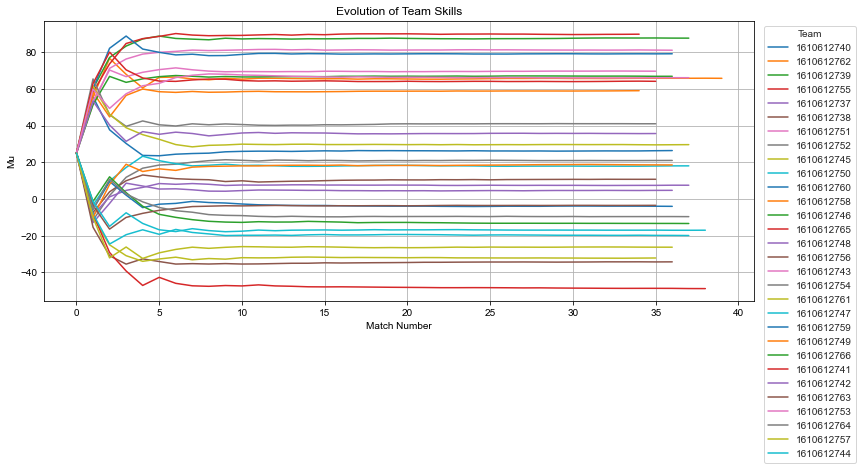

In [65]:
# Figure showing the evolution of skills for all the teams
plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.set_style("whitegrid")

for team, mu_sigma_values in skills_history.items():
    mu_values = [mu for mu, sigma in mu_sigma_values]
    x_values = range(len(mu_values))
    sns.lineplot(x=x_values, y=mu_values, ax=ax, label=team)

plt.title("Evolution of Team Skills")
plt.xlabel('Match Number')
plt.ylabel('Mu')
plt.legend(title='Team', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# Prints a table of all team's 
sorted_skills_df = skills_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_df.iterrows()):
    team = row['team']
    team = id2name(team, teams)
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i+1:2d} -- Team: {team:<15s} | mu: {mu:>7.2f} | sigma: {sigma:>7.2f}")

 1 -- Team: 76ers           | mu:   89.75 | sigma:    0.04
 2 -- Team: Cavaliers       | mu:   87.60 | sigma:    0.04
 3 -- Team: Nets            | mu:   81.02 | sigma:    0.04
 4 -- Team: Thunder         | mu:   79.09 | sigma:    0.04
 5 -- Team: Nuggets         | mu:   69.59 | sigma:    0.04
 6 -- Team: Clippers        | mu:   66.82 | sigma:    0.04
 7 -- Team: Magic           | mu:   66.05 | sigma:    0.04
 8 -- Team: Jazz            | mu:   65.72 | sigma:    0.03
 9 -- Team: Bulls           | mu:   64.09 | sigma:    0.04
10 -- Team: Kings           | mu:   58.97 | sigma:    0.04
11 -- Team: Pacers          | mu:   40.97 | sigma:    0.04
12 -- Team: Mavericks       | mu:   35.64 | sigma:    0.04
13 -- Team: Raptors         | mu:   29.59 | sigma:    0.04
14 -- Team: Pelicans        | mu:   26.36 | sigma:    0.04
15 -- Team: Knicks          | mu:   20.98 | sigma:    0.04
16 -- Team: Bucks           | mu:   18.54 | sigma:    0.04
17 -- Team: Timberwolves    | mu:   18.04 | sigma:    0.

In [ ]:
sorted_skills_sh_df = skills_shuffle_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_sh_df.iterrows()):
    team = row['team']
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i+1:2d} -- Team: {team:<15s} | mu: {mu:>7.2f} | sigma: {sigma:>7.2f}")